# Apply vgg16 model and predict class for test data of https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition and submit prediction results to Kaggle.

In [91]:
# Module versions
import sys
import keras
import theano
import numpy
import pandas

print("Python version:" + sys.version)
print("Keras version:" + keras.__version__)
print("Theano version:" + theano.__version__)
print("Numpy version:" + numpy.__version__)

Python version:2.7.13 |Anaconda 4.4.0 (64-bit)| (default, Dec 20 2016, 23:09:15) 
[GCC 4.4.7 20120313 (Red Hat 4.4.7-1)]
Keras version:2.0.4
Theano version:0.9.0
Numpy version:1.12.1


## Setup Keras and its backend before using it

In [92]:
print("Keras backend:" + keras.backend.backend())

print("Keras backend image data format:Before:" + keras.backend.image_data_format())
# change image_data_format to channels_first
keras.backend.set_image_data_format('channels_first')
print("Keras backend image data format:After:" + keras.backend.image_data_format())
print("Keras backend image_dim_ordering:After:" + keras.backend.image_dim_ordering())

print("Keras backend epsilon:Before:" + str(keras.backend.epsilon()))
# change epsilon to 1e-7
keras.backend.set_epsilon(1e-7)
print("Keras backend epsilon:After:" + str(keras.backend.epsilon()))

print("Keras backend floatx:Before:" + str(keras.backend.floatx()))
# change floatx to float32
keras.backend.set_floatx('float32')
print("Keras backend floatx:After:" + str(keras.backend.floatx()))

Keras backend:theano
Keras backend image data format:Before:channels_first
Keras backend image data format:After:channels_first
Keras backend image_dim_ordering:After:th
Keras backend epsilon:Before:1e-07
Keras backend epsilon:After:1e-07
Keras backend floatx:Before:float32
Keras backend floatx:After:float32


In [93]:
import utils; reload(utils)
import vgg16Shabeer; reload(vgg16Shabeer)
%matplotlib inline
import matplotlib.pyplot as plt
from utils import plots
from vgg16Shabeer import Vgg16Shabeer

### Training, Validation and Testing data path

#### Enable either floydhub or local path

In [94]:
floyd_or_local = "local"
dataset = "sample" # sample or global

In [95]:
#path containing sample, train, valid and test1 directries
global_path = ""
# trimmed down version of train,validation and testing data from above path
sample_path = ""
# path to save any artifacts created
output_path = ""

if floyd_or_local == "local":
    global_path = "data/dogscats/"
    sample_path = "data/dogscats/sample/"
    output_path = "./"
    utils.set_keras_cache_dir("/home/shabeer/.keras/")
    
    # Prepare local global/sample test path
    # Ignore errors if this notebook is run in non-local environment.
    !global_path="data/dogscats/"
    !mkdir -p $global_path/test1/unknown/
    !mv $global_path/test1/*.jpg $global_path/test1/unknown/

    !sample_path="data/dogscats/sample/"
    !mkdir -p $sample_path/test1/unknown/
    !cp $global_path/test1/unknown/4*09.jpg $sample_path/test1/unknown/    
    
else:
    global_path = "/input/dogscats/"
    sample_path = "/input/dogscats/sample/"
    output_path = "/output/"
    utils.set_keras_cache_dir("/input/models/")    

if dataset == "sample":
    path = sample_path
else:
    path = global_path

test_path = path + "/test1/"    

mv: cannot stat 'data/dogscats//test1/*.jpg': No such file or directory


### Create vgg16 model with its weights loaded

In [96]:
vgg = Vgg16Shabeer()

In [97]:
# Based on memory available, choosing a medium value. Max could be 64, above which could be - out of memory
batch_size = 16
train_batches = vgg.get_batches(path + '/train/', batch_size = batch_size, class_mode='categorical')
validation_batches = vgg.get_batches(path + '/valid/', batch_size = batch_size)
#test_batches = vgg.get_batches(path + '../test1/', batch_size = batch_size * 4)

Found 160 images belonging to 2 classes.
Found 40 images belonging to 2 classes.


In [98]:
print("Number of classes in vgg model before fine tuning:" + str(len(vgg.classes)))
# fine tune vgg16 model to 2 classes - dogs and cats
vgg.finetune(train_batches)
print("Number of classes in vgg model before after tuning:" + str(len(vgg.classes)))
print("Classes after tuning:" + str(vgg.classes))

Number of classes in vgg model before fine tuning:1000
Number of classes in vgg model before after tuning:2
Classes after tuning:['cats', 'dogs']


## Train and validate vgg16 model to 2 classes data.

In [99]:
import datetime
time_before_starting_training = datetime.datetime.now()
print(time_before_starting_training)

# train & validate
vgg.fit(batches= train_batches, val_batches= validation_batches, nb_epoch=1)
time_after_training =  datetime.datetime.now() 
print(time_after_training)

train_imgs, train_labels = next(train_batches)
print("train_imgs shape:" + str(train_imgs.shape))

print("Time taken to train & validate: " + str(time_after_training - time_before_starting_training))

2017-06-11 14:42:51.371132
2017-06-11 14:42:51.372683
train_imgs shape:(16, 3, 224, 224)
Time taken to train & validate: 0:00:00.001551


## Save model and weights

In [100]:
print("Saving model configuration.")
model_json = vgg.model.to_json()
#print(model_json)
with open(output_path + '/model.json', 'w') as f:
    f.write(model_json)
print("Saved model configuration.")
    
#serialize weights to hdf5
model_weights = vgg.model.save_weights(output_path + '/model_weights.h5')
print("Saved model weights.")

Saving model configuration.
Saved model configuration.
Saved model weights.


## Test and predict labels

In [102]:
test_batches = vgg.get_batches(test_path, batch_size = 8, class_mode=None)
imgs = next(test_batches)
print(imgs.shape)
preds, idxs, classes = vgg.predict(imgs)

Found 11 images belonging to 1 classes.
(8, 3, 224, 224)


[[ 0.9531  0.0469]
 [ 0.6667  0.3333]
 [ 0.6753  0.3247]
 [ 0.3541  0.6459]
 [ 0.9929  0.0071]
 [ 0.3963  0.6037]
 [ 0.9085  0.0915]
 [ 0.8995  0.1005]]
[0 0 0 1 0 1 0 0]
['cats', 'cats', 'cats', 'dogs', 'cats', 'dogs', 'cats', 'cats']


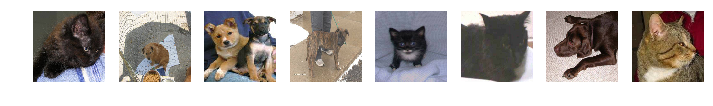

In [103]:
plots(imgs[0:11])
print(preds[0:11])
print(idxs[0:11])
print(classes[0:11])

In [105]:
time_before_starting_testing = datetime.datetime.now()
print(time_before_starting_testing)
batch_size = 8

# both test_batches and predictions below are generators
#test_batches, predictions = vgg.test(test_path, batch_size = 8)
test_batches = vgg.get_batches(test_path, batch_size=batch_size, class_mode =None)
print("List of images across all test_batches: " + str(test_batches.samples))

import math
steps = int(math.ceil(test_batches.samples*1.0/batch_size))
print("Number of steps:" + str(steps))

predictions  = vgg.model.predict_generator(test_batches, steps = steps, verbose=1)

time_after_testing = datetime.datetime.now()
print(time_after_testing)

time_taken = time_after_testing - time_before_starting_training

print("Time taken to test: " + str(time_taken))

print(predictions.shape)
print(predictions[0:11])
print("Probability of image being a dog:" + str(predictions[0:11,1]))

2017-06-11 14:43:08.402826
Found 11 images belonging to 1 classes.
List of images across all test_batches: 11
Number of steps:2
2/2 [==============================] - 6s     
2017-06-11 14:43:14.627701
Time taken to test: 0:00:23.256569
(11, 2)
[[ 0.6753  0.3247]
 [ 0.7727  0.2273]
 [ 0.3541  0.6459]
 [ 0.9085  0.0915]
 [ 0.3963  0.6037]
 [ 0.8995  0.1005]
 [ 0.9531  0.0469]
 [ 0.3493  0.6507]
 [ 0.9929  0.0071]
 [ 0.833   0.167 ]
 [ 0.6667  0.3333]]
Probability of image being a dog:[ 0.3247  0.2273  0.6459  0.0915  0.6037  0.1005  0.0469  0.6507  0.0071  0.167   0.3333]


## Construct Kaggle submission

In [106]:
print(vgg.classes)
idx = numpy.argmax(predictions, axis = 1) # idx within each row of predictions, which contains max probability.
print(idx[0:11])
classes_predicted = map(lambda i: vgg.classes[i], idx)
print(classes_predicted[0:11])

from pandas import Series,DataFrame

print(test_batches.filenames[0:11])
filenames = map(lambda f: f.replace('unknown/', '').replace('.jpg', ''), test_batches.filenames)
print(filenames[0:11])

# probability of image being a dog ( 1=dog, 0=cat)
dog_prob = [str("%.12f" % p) for p in predictions[:,1]]

p = pandas.concat([Series(filenames), Series(dog_prob)], axis = 1, keys = ['id', 'label'])
print(p[0:11])
p.to_csv(output_path + '/dogs-vs-cats-redux-kernels-edition_predictions_shabeer.csv', header= True, mode='w', index=False)

['cats', 'dogs']
[0 0 1 0 1 0 0 1 0 0 0]
['cats', 'cats', 'dogs', 'cats', 'dogs', 'cats', 'cats', 'dogs', 'cats', 'cats', 'cats']
['unknown/4309.jpg', 'unknown/4709.jpg', 'unknown/4409.jpg', 'unknown/4809.jpg', 'unknown/4909.jpg', 'unknown/4009.jpg', 'unknown/409.jpg', 'unknown/4109.jpg', 'unknown/4609.jpg', 'unknown/4509.jpg', 'unknown/4209.jpg']
['4309', '4709', '4409', '4809', '4909', '4009', '409', '4109', '4609', '4509', '4209']
      id           label
0   4309  0.324680417776
1   4709  0.227274850011
2   4409  0.645893514156
3   4809  0.091549895704
4   4909  0.603687942028
5   4009  0.100541643798
6    409  0.046920917928
7   4109  0.650712013245
8   4609  0.007065440994
9   4509  0.167011037469
10  4209  0.333345532417


## Loading the fully trained model in floydhub for entire dogscats dataset

In [107]:
from keras.models import model_from_json
from keras.optimizers import Adam
import os
import numpy as np

global vgg_mean
vgg_mean = np.array([123.68, 116.779, 103.939], dtype=np.float32).reshape((3,1,1))

# Using model.json generated after moving vgg_mean instead 
json_file = open(output_path + 'model.json', 'r')
model_json = json_file.read()
json_file.close()

# load model config
loaded_model = model_from_json(model_json)

# load model weights
loaded_model.load_weights(output_path + 'model_weights_fully_trained.h5')

# Compile loaded model
loaded_model.compile(optimizer = Adam(lr = 0.001), loss='categorical_crossentropy', metrics = ['accuracy'])



## Transform given image to proper size and channels_first

In [175]:
def transform(img, verbose = 0):
    if verbose == 1:
        print("Image original shape: " + str(img.shape))
    # resize each image from (499, 478, 3) to (224, 224, 3)
    new_shape = (224,224)
    img = scipy.misc.imresize(img, new_shape)
    if verbose == 1:
        print("Shape after resizing before moving axis: " + str(img.shape))

    # Move axis
    # from 2nd axis to 0th axis. 
    # So net result is (224, 224, 3) shape is turned to (3,224,224)
    img = np.moveaxis(img, 2, 0)
    if verbose == 1:
        print("Shape after moving axis: " + str(img.shape))
    return img

## Predict category for all images or one random image by loading fully trained model on all training examples

In [196]:
import cv2
import numpy as np
from numpy import random
import glob
import os

# truncate file before appending it below
csv_file = output_path + '/dogs-vs-cats-redux-kernels-edition_predictions_shabeer.csv'
f = open(csv_file, 'w')
f.truncate()
f.close()

print("Starting time: " + str(datetime.datetime.now()))

# batch images into i*.jpg into 10 batches containing 12500 images, 1*.img will have more
# compared to others
for i in np.arange(1, 10):
    images = []
    images_filepaths = []
    random_image_fpath = global_path + "/test1/unknown/" + str(random.randint(1, 12500+1)) + ".jpg"
    all_images_path = global_path + "/test1/unknown/" + str(i) + "*.jpg"

    single_or_all_images = "all_images" # single or all_images
    if single_or_all_images == "single":
        image_path = random_image_fpath    
    else:
        image_path = all_images_path

    print("Processing images of file pattern: htop
          " + image_path)

    for image_fpath in glob.glob(image_path):
        img = cv2.imread(image_fpath)
        if single_or_all_images == "single":
            original_img = img
        img = transform(img)
        images.append(img)
        images_filepaths.append(image_fpath)

    images = np.array(images)
    print("Shape: " + str(images.shape))
    print("Loaded given images: " + str(datetime.datetime.now()))

    probabilities = loaded_model.predict(images)
    print("Prediction completed for given images: " + str(datetime.datetime.now()))
    high_prob_idx = np.argmax(probabilities, axis = 1)

    if single_or_all_images == "single":
        print(high_prob_idx)
        print("Predicted probability for each class:" + str(vgg.classes) + ", prob: " + str(probabilities))
        print("Below image belongs to " +  str(vgg.classes[high_prob_idx[0]]) + " category")
        plt.imshow(original_img)

    # Persist dog prob into csv    
    # probability of image being a dog ( 1=dog, 0=cat)
    dog_prob = [str("%.12f" % p) for p in probabilities[:,1]]

    # convert data/dogscats//test1/unknown/9944.jpg  to 9944
    images_filepaths = [i.split("/")[5].split(".")[0] for i in images_filepaths]

    p = pandas.concat([Series(images_filepaths), Series(dog_prob)], axis = 1, keys = ['id', 'label'])
    print("Sample output: " + str(p[0:11]))
    p.to_csv(csv_file, header= True, mode='a', index=False)
          
    # Free up memory
    del images
    del probabilities
    del dog_prob
    del images_filepaths
    del p
    
print("Ending time: " + str(datetime.datetime.now()))

Starting time: 2017-06-11 16:07:47.890323
Processing images of file pattern:data/dogscats//test1/unknown/1*.jpg
Shape: (3612, 3, 224, 224)
Loaded given images: 2017-06-11 16:08:48.070564
Prediction completed for given images: 2017-06-11 16:37:41.464906
Sample output:        id           label
0   11577  0.000000000000
1   11591  0.000000000000
2   11446  0.000000000000
3   12063  0.000000000000
4   11110  0.000000000000
5   11902  1.000000000000
6   10962  1.000000000000
7   10481  0.000000000000
8    1843  0.000000000000
9   12002  0.000000000000
10   1501  0.000013462006
Processing images of file pattern:data/dogscats//test1/unknown/2*.jpg
Shape: (1111, 3, 224, 224)
Loaded given images: 2017-06-11 16:38:01.155016
Prediction completed for given images: 2017-06-11 16:46:39.923268
Sample output:       id           label
0   2484  1.000000000000
1   2684  1.000000000000
2   2497  0.000000000000
3   2314  0.000006120566
4    296  1.000000000000
5   2966  0.000000000000
6   2591  0.0000000

## Remove multiple lines having repated headers id,label from the csv file before uploading to kaggle

# Earned scored (log loss error) of 0.52219 (lesser the better) with rank: 941.

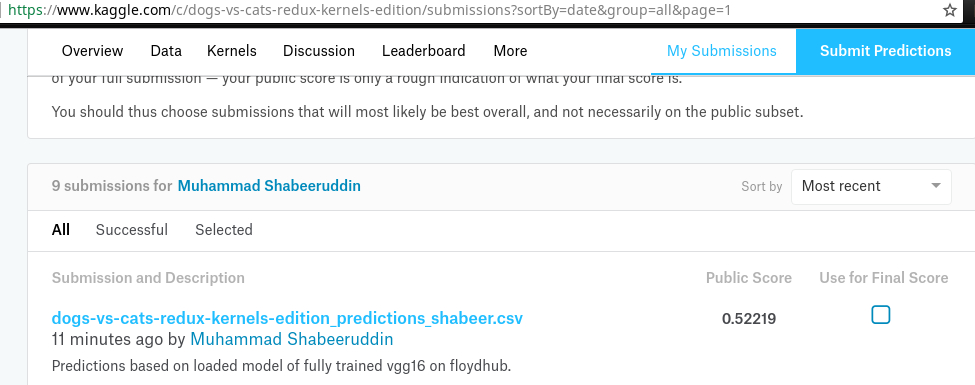

In [228]:
from IPython.core.display import Image,display
Image('Dogs vs. Cats Redux Kernels Edition Shabeer.jpg')